In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5' 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
fpath = 'C:/Users/zambr/OneDrive/Escritorio/7mo Semestre/Dataset Mineria/Dataset3'
random_seed = 9
categories = os.listdir(fpath)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))
TAMANO_IMG = 224

List of categories =  ['ojosAbiertos', 'ojosCerrados'] 

No. of categories =  2


In [3]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread((fpath+"/"+category+"/"+image_name), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (TAMANO_IMG, TAMANO_IMG))
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            #img = img.reshape(TAMANO_IMG, TAMANO_IMG, 1) 
            img_lst.append(np.array(img))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  7166 
No. of labels loaded =  7166
<class 'list'> <class 'list'>


In [4]:
images = np.array(images).reshape(-1, TAMANO_IMG, TAMANO_IMG, 3)

In [5]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (7166, 224, 224, 3) 
Labels shape =  (7166,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


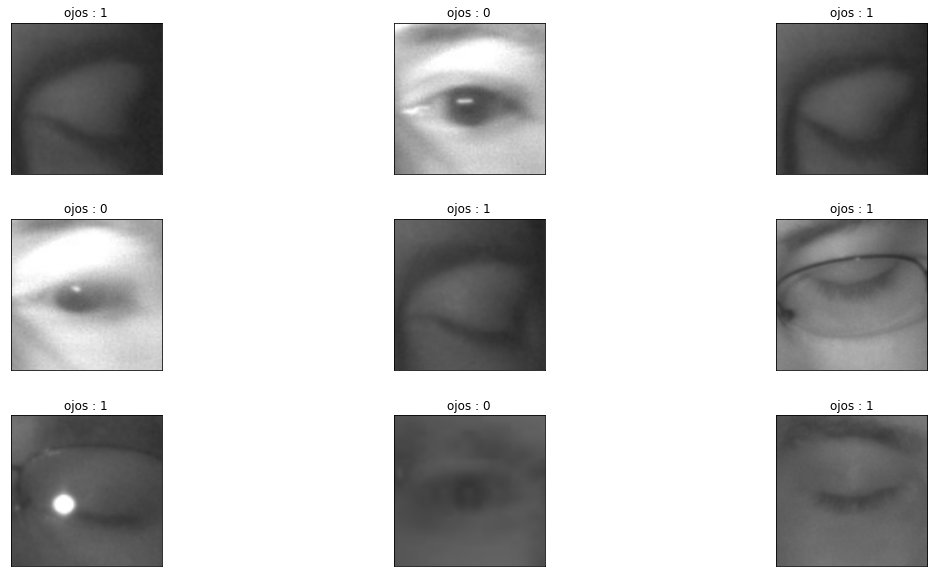

In [6]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('ojos : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

Prepare data for training the CNN model

In [7]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 7163 7164 7165]

'n' values after shuffling =  [3129 3163 2048 ... 6782 4444  382]


In [8]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (7166, 224, 224, 3) 
Labels shape after shuffling =  (7166,)


In [9]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (7166, 224, 224, 3)


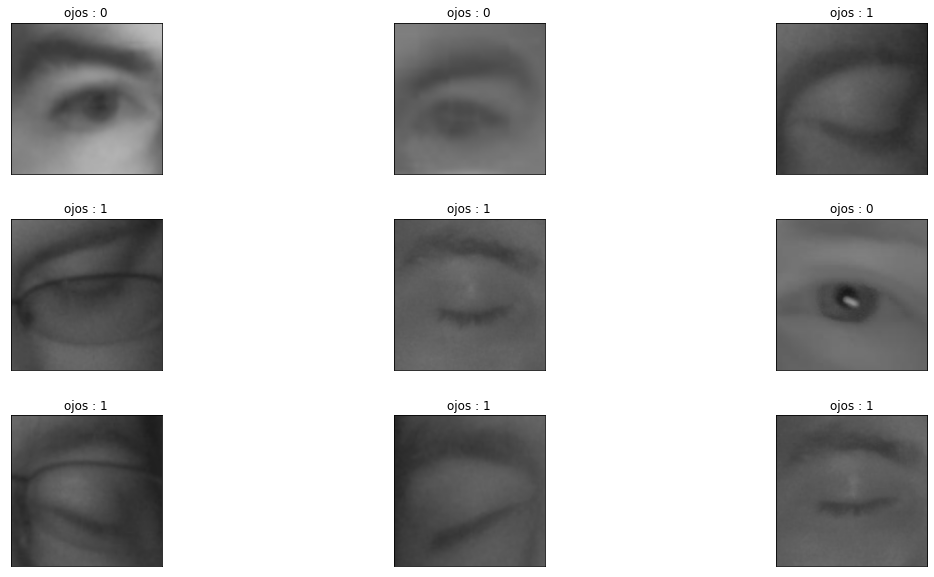

In [10]:
display_rand_images(images, labels)

In [11]:
train_X, test_X, train_Y, test_Y= train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

print("train_ds shape = ",train_X.shape)
print("train_labels shape = ",train_Y.shape)
print("\ntest_ds shape = ",test_X.shape)
print("test_labels shape = ",test_Y.shape)

train_ds shape =  (5732, 224, 224, 3)
train_labels shape =  (5732,)

test_ds shape =  (1434, 224, 224, 3)
test_labels shape =  (1434,)


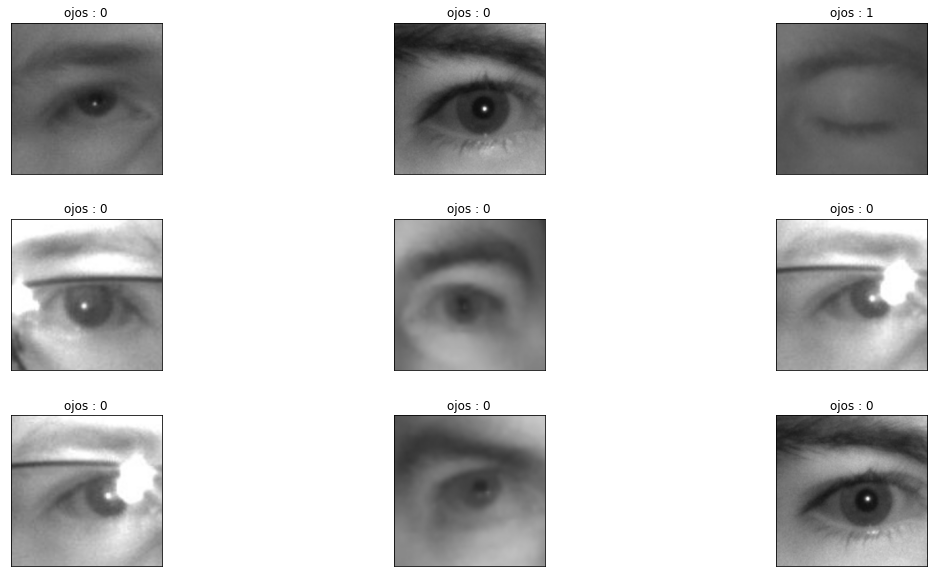

In [12]:
display_rand_images(train_X, train_Y)

Define CNN model

In [13]:
from tensorflow.keras.callbacks import TensorBoard

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
model = tf.keras.applications.mobilenet.MobileNet()

In [15]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [16]:
base_input = model.layers[0].input
base_output = model.layers[-4].output


In [17]:
Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer)
final_output = layers.Activation('sigmoid')(final_output)
new_model = keras.Model(inputs = base_input, outputs = final_output)


In [18]:
new_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [19]:
new_model.compile(loss="binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])


In [20]:
history = new_model.fit(train_X, train_Y, epochs = 2, validation_split = 0.1)


Epoch 1/2
162/162 [==============================] - 438s 3s/step - loss: 0.0342 - accuracy: 0.9888 - val_loss: 0.0424 - val_accuracy: 0.9913
Epoch 2/2
162/162 [==============================] - 364s 2s/step - loss: 0.0080 - accuracy: 0.9983 - val_loss: 0.0092 - val_accuracy: 0.9983


In [21]:
_, acc = new_model.evaluate(test_X, test_Y, verbose=0)

print('> %.2f' % (acc * 100.0))

> 99.37


In [22]:
model_probs = new_model.predict(test_X, verbose=0)
# predict crisp classes for test set
model_classes = np.argmax(model_probs,axis=1)
# reduce to 1d array
model_probs = model_probs[:, 0]
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_Y, model_classes)*100
# precision tp / (tp + fp)
precision = precision_score(test_Y, model_classes, average='weighted')*100
# recall: tp / (tp + fn)
recall = recall_score(test_Y, model_classes, average='weighted')*100
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_Y, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

Accuracy: 45.96
F1 score: 28.94
Precision: 21.12
Recall: 45.96


C:\Users\zambr\.conda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


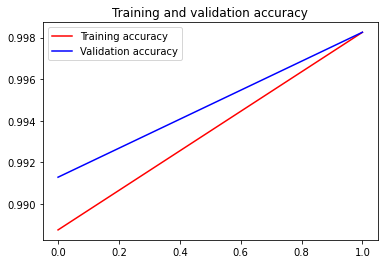

<Figure size 432x288 with 0 Axes>

In [23]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [24]:
new_model.save('CNNMb.h5')